# Preamble
The codeblocks below are there to important the right packages, provide some helper functions, and hardcode a number of often used values. If you find yourself needed to make adjustments to these codeblocks to make the code work, please let us know as this most likely means that something has gone wrong in our implementation.

In [2]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from tqdm import tqdm

import torch.distributions as D

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation

from scipy.stats import multivariate_normal

In [3]:
def reset_seeds(seed=42):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  np.random.seed(seed)

# Administrative Information
Again, please note that none of the tasks set are supposed to be extremely challenging and if you do run into any problems, chances are high that this is due to unclarity on our side. As such, if you are stuck on a task for a longer time, do please reach out to lars@aims.ac.za

This week we will be organizing the coding task slightly different:
- The assignment is only introduced at the end of the notebook. This assignment will ask you to perform some small experiment to see how different hyperparameters or modelling decisions change the final outcome.
- The assignment will primarily ask you to implement some logging + visualization and to interpret the results.
- Additional optional experiments will be proposed, but it is not neccesary to complete these.
- Discuss your experimental results in the markdown block containing the keyword "*Answer:*".


Lastly, to help us in improving the coding assignments, please fill in the anonymous feedback [form](https://forms.gle/vVBXm7nhW94yMkHr8) (you can do this for every assigment, just make sure to pick the correct day you just finished in the sheet). We highly appreciate your feedback, positive and negative!

# Variational Auto Encoder
In today's notebook we will be implementing a Variational Auto Encoder as described in the 3rd chapter of the lecture notes. We refer to the lecture notes to find a description of the different steps.

In [4]:
reset_seeds()

# Parameters for the GMM components
n_data = 500  # Total number of data points
n_gaussians = 10  # Number of GMM mixture components

# Generate parameters for GMM components
means = torch.rand(n_gaussians, 2) * 10 - 5  # Uniformly distributed in [-5, 5]
stds = torch.rand(n_gaussians, 2) * 1 + 0.5  # Uniformly distributed in [0.5, 1.5]

mixture_weights = torch.ones(n_gaussians) / n_gaussians  # Equal weights for simplicity
mixture_distribution = torch.distributions.Categorical(mixture_weights)
component_distribution = torch.distributions.Independent(torch.distributions.Normal(means, stds), 1)
gmm = torch.distributions.MixtureSameFamily(mixture_distribution, component_distribution)

# Sample data from the GMM
X = gmm.sample((n_data,))

In [5]:
X_max = X.max(dim=0)[0]
X_min = X.min(dim=0)[0]

X = (X - X_min) / (X_max - X_min) * 2 - 1

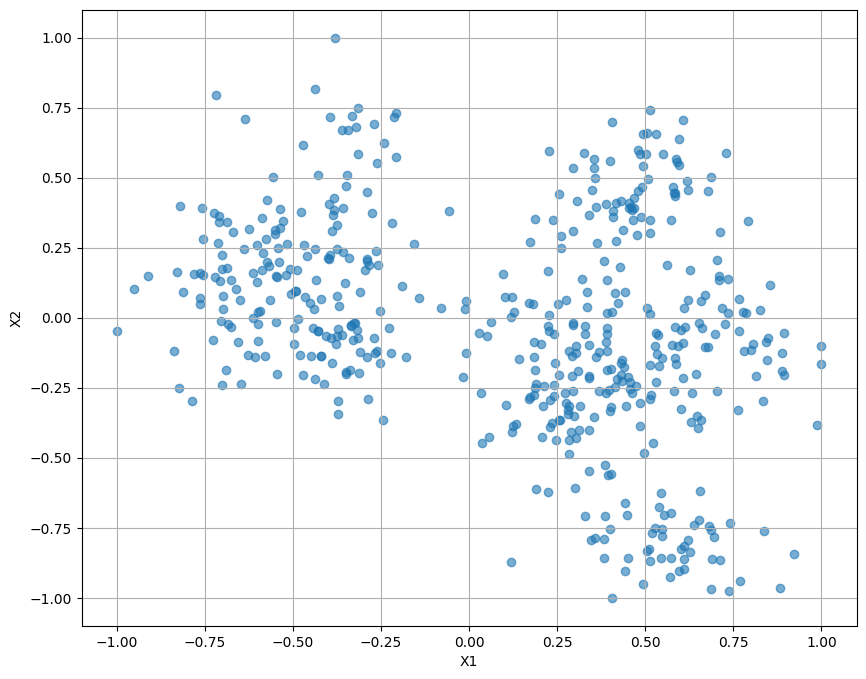

In [6]:
# Plot the data
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], alpha=0.6)

plt.xlabel('X1')
plt.ylabel('X2')
plt.grid(True)
plt.show()

## VAE Architecture
In the following code blocks we will be implementing the VAE architecture. For this purpose we will first implement the individual components, the Encoder and Decoder networks, before combining them together and implementing the reparameterization trick.

### **Encoder**
The Encoder Network, $Q$, takes as input a single datasample and uses it to predict the mean and variance of the latent gaussian distribution over $z$. We are free in the choise of architecture for the encoder in general, but we do need to make sure that it has two output streams; one for the mean and one for the variance.

In [7]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dim):
        super(Encoder, self).__init__()

        modules = []
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Linear(input_dim, h_dim),
                    nn.ReLU(True)
                )
            )
            input_dim = h_dim  # Update the input dimension for the next layer

        self.encoder = nn.Sequential(*modules)
        self.mu = nn.Linear(hidden_dims[-1], latent_dim)  # Output layer for mean
        self.log_var = nn.Linear(hidden_dims[-1], latent_dim)  # Output layer for log variance

    def forward(self, x):
        hidden = self.encoder(x)
        return self.mu(hidden), self.log_var(hidden)


### Decoder
Similar to the encoder we are relatively free to implement the decoder using any appropriate architecture. Below we have chosen for a simple MLP with variable number of hidden layers. Note that we use a tanh layer to scale the inputs. This is also the reason why we have scaled the dataset to be between 0 and 1.

In [8]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dims, output_dim):
        super(Decoder, self).__init__()

        modules = []
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Linear(latent_dim, h_dim),
                    nn.ReLU()
                )
            )
            latent_dim = h_dim  # Update the input dimension for the next layer

        # Add the output layer with tanh activation
        modules.append(nn.Linear(hidden_dims[-1], output_dim))
        modules.append(nn.Tanh())

        self.decoder = nn.Sequential(*modules)

    def forward(self, z):
        return self.decoder(z)

Lastly, we combine the encoder and the decoder into the VAE. We use the same architecture (in terms of the number of layers and nodes used) for both the encoder and decoder in this example, but this is not a requirement.

Observe that the forward function uses the reparameterization trick. As we discussed this allows for low variance estimation of the gradient wrt the parameters of the encoder.

In [9]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dim, output_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dims, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dims, output_dim)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var

## Training Loop
With the VAE implemented we can start to train it using the ELBO as our loss. We have seen the ELBO a number of times during the lectures already, but once you look into the code of many VAE implementations you will find that the loss is often described in terms of a reconstruction loss and a KL-Divergence loss.

Fortunately, this is not different from the ELBO as we discussed it during the lectures. In the derivation below, starting from the ELBO, the terms in the last line are respectively refered to as the reconstruction loss and the KL-Divergence loss.

\begin{align}
  \log p(x) &\geq \sum_z q(z|x) (\log p(x,z) - \log q(z|x)) \\
            &\geq \sum_z q(z|x) (\log p(x|z) - \log p(z) - \log q(z|x)) \\
            &\geq \sum_z q(z|x) (\log p(x|z)) + \sum_z q(z|x)(\log q(z|x)
            - \log p(z)) \\
            &\geq \mathbb{E}_{q(z|x)}[\log p(x|z)] + \text{D}_{\text{KL}}[q(z|x)||p(z)]
\end{align}

A last note about the loss used is that you will find that we use the MSE-loss for the reconstruction loss, and scale the kld-loss with a $\beta$ parameter. We can interpret this as using a Gaussian $P(x|z)$ with ${\beta}$ as it's variance. This is relatively simple to proof if you want to give yourself a challenge.

In theory, the choice of $\beta$ is relatively important and we will focus on it during the assignment below.



In [26]:
# Hyperparameters
input_dim = 2
hidden_dims = [32, 64, 32]
latent_dim = 2
output_dim = 2
lr = 1e-3
epochs = 1000
beta = .03  # The beta hyperparameter for the KL divergence term


model = VAE(input_dim, hidden_dims, latent_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):
        optimizer.zero_grad()
        # Forward pass
        x_reconstructed, mu, log_var = model(X)

        # Reconstruction loss
        recon_loss = nn.functional.mse_loss(x_reconstructed, X, reduction='sum')

        # KL divergence loss
        kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # Total loss with the beta trade-off
        loss = recon_loss + beta * kld_loss

        # Backward pass
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")


Epoch 0, Loss: 204.87359619140625
Epoch 100, Loss: 74.70037841796875
Epoch 200, Loss: 52.73664093017578
Epoch 300, Loss: 49.82150650024414
Epoch 400, Loss: 50.046485900878906
Epoch 500, Loss: 48.65203094482422
Epoch 600, Loss: 50.178199768066406
Epoch 700, Loss: 48.624107360839844
Epoch 800, Loss: 48.65760040283203
Epoch 900, Loss: 47.48551940917969


## Evaluation
Given the trained model, we can now evaluate how effectively it can be used to sample from our data distribution.

### Reconstructed data
The plot below show the original data and the reconstructed data. You can also observe here how the beta parameter is used to scale the Gaussian used in the last step of the reconstruction.

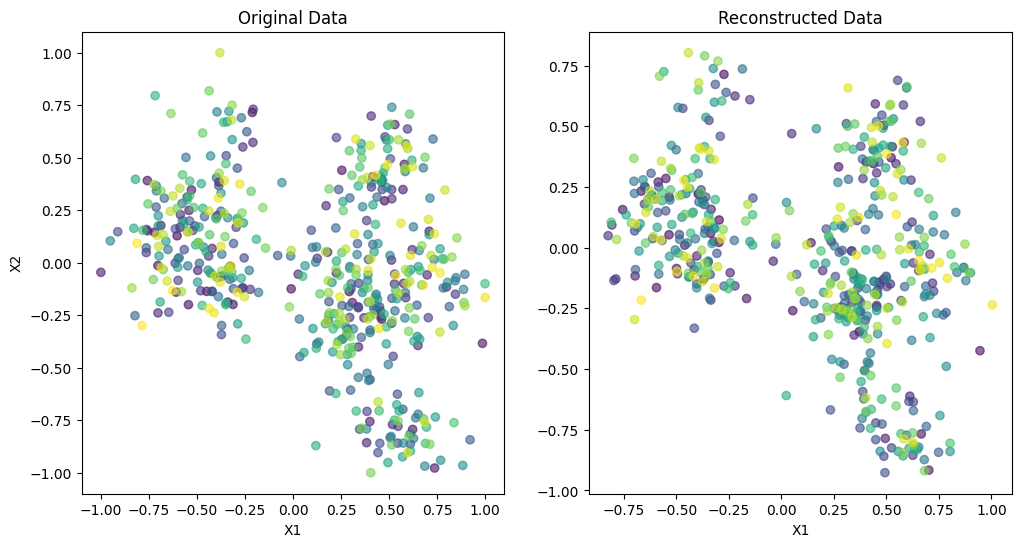

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_vae_with_colors(X, model):
    model.eval()

    with torch.no_grad():
        # Reconstruct data through the VAE
        X_reconstructed, _, _ = model(X)
        X_reconstructed_np = X_reconstructed.detach().numpy()

    # Here, we sample from a normal distribution around the means
    X_reconstructed_sampled = np.random.normal(loc=X_reconstructed_np, scale=beta)

    # Generate a color map based on the index of each data point
    colors = plt.cm.viridis(np.linspace(0, 1, len(X)))

    # Plot original data
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(X[:, 0], X[:, 1], color=colors, alpha=0.6)
    plt.title('Original Data')
    plt.xlabel('X1')
    plt.ylabel('X2')

    # Plot reconstructed data
    plt.subplot(1, 2, 2)
    plt.scatter(X_reconstructed_sampled[:, 0], X_reconstructed_sampled[:, 1], color=colors, alpha=0.6)
    plt.title('Reconstructed Data')
    plt.xlabel('X1')

    plt.show()

plot_vae_with_colors(X, model)


### Latent representation
For a VAE to be effective in generating new samples it is important that the original datasamples are fully encoded to a Gaussian latent representation. If this is not the case there might be areas in the latent representation that we would like to sample from that have not been sufficiently learned to decode.

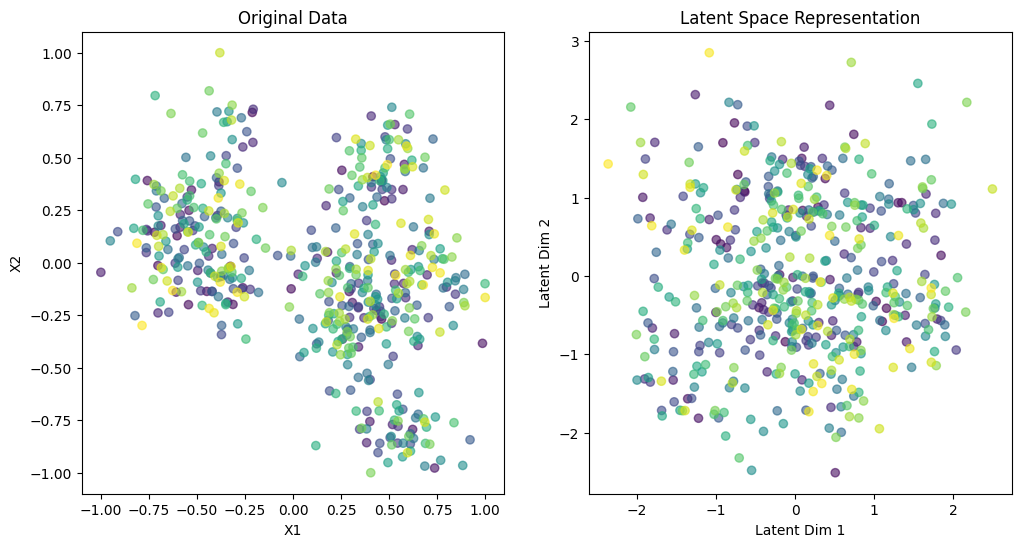

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_data_and_latent_space(X, model):
    model.eval()

    with torch.no_grad():
        # Encode data to get the mean and log variance of the latent space distribution
        mu, log_var = model.encoder(X)
        std = torch.exp(0.5 * log_var)

        # Sample from the distribution using the reparameterization trick
        eps = torch.randn_like(std)
        z = mu + eps * std  # Reparameterized sample

        sampled_z_np = z.detach().numpy()

    # Generate a color map based on the index of each data point
    colors = plt.cm.viridis(np.linspace(0, 1, len(X)))

    # Plot original data
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.scatter(X[:, 0], X[:, 1], color=colors, alpha=0.6)
    plt.title('Original Data')
    plt.xlabel('X1')
    plt.ylabel('X2')

    # Plot latent space representation
    plt.subplot(1, 2, 2)
    plt.scatter(sampled_z_np[:, 0], sampled_z_np[:, 1], color=colors, alpha=0.6)
    plt.title('Latent Space Representation')
    plt.xlabel('Latent Dim 1')
    plt.ylabel('Latent Dim 2')

    plt.show()

plot_data_and_latent_space(X, model)


### Generating new samples
Now that we are relatively sure that the encoded latent space is a Gaussian, we can simply generate new data samples by sampling from the data distribution and consequtively decoding this sample.

<ipython-input-29-fd668ef133f2>:28: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap))
<ipython-input-29-fd668ef133f2>:38: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap))


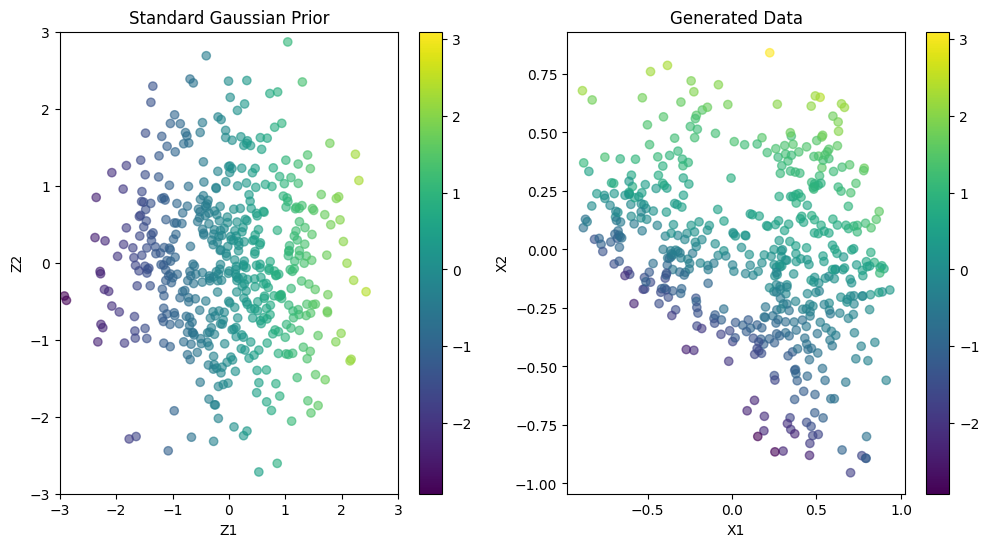

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_prior_and_generated_data_mapped_gradient(model, num_samples=500):
    model.eval()

    with torch.no_grad():
        # Sample from the prior (standard normal distribution in the latent space)
        z_samples = torch.randn(num_samples, latent_dim)

        # Decode the samples to generate data
        generated_means = model.decoder(z_samples).cpu().numpy()
        generated_data = np.random.normal(loc=generated_means, scale=beta)

    # Use the first dimension of z_samples for coloring both plots
    z_colors = z_samples[:, 0].numpy()

    # Create a colormap based on the first dimension of the latent samples
    norm = plt.Normalize(vmin=min(z_colors), vmax=max(z_colors))
    cmap = plt.get_cmap('viridis')
    colors = cmap(norm(z_colors))

    # Plot the standard Gaussian prior with a gradient color based on the first dimension
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(z_samples[:, 0], z_samples[:, 1], color=colors, alpha=0.6)
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap))
    plt.title('Standard Gaussian Prior')
    plt.xlim([-3, 3])
    plt.ylim([-3, 3])
    plt.xlabel('Z1')
    plt.ylabel('Z2')

    # Plot the generated data points with the same gradient color
    plt.subplot(1, 2, 2)
    plt.scatter(generated_data[:, 0], generated_data[:, 1], color=colors, alpha=0.6)
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap))
    plt.title('Generated Data')
    plt.xlabel('X1')
    plt.ylabel('X2')

    plt.show()

plot_prior_and_generated_data_mapped_gradient(model)


### Likelihood
Lastly, we plot the likelihood of our model below. Note that VAE's do not provide a exact likelihood method. Instead we approximate it below using MC.

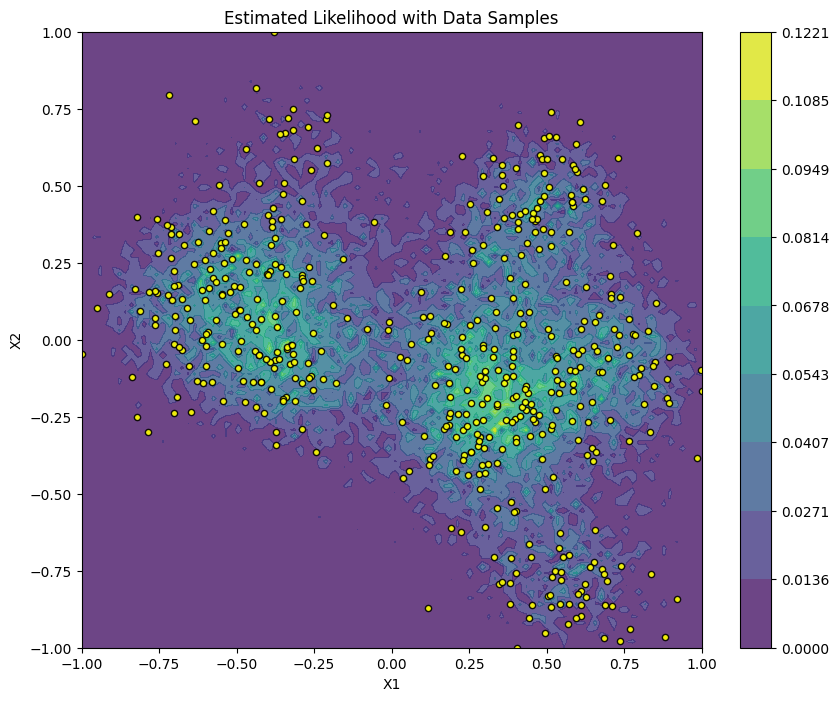

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def visualize_likelihood_on_grid_with_data_samples(decoder, X, latent_dim, grid_width=1, grid_height=1, grid_resolution=100, std_dev=0.1):
    # Define the grid over the data space
    x = np.linspace(-grid_width, grid_width, grid_resolution)
    y = np.linspace(-grid_height, grid_height, grid_resolution)
    X_grid, Y_grid = np.meshgrid(x, y)
    grid_shape = X_grid.shape

    # Flatten the grid for batch processing
    grid_points = np.vstack((X_grid.ravel(), Y_grid.ravel())).T

    # Convert to a PyTorch tensor
    grid_points_tensor = torch.from_numpy(grid_points).float()

    # Perform Monte Carlo approximation of the likelihood on the grid
    likelihoods = np.zeros(grid_points.shape[0])

    # Number of Monte Carlo samples
    num_samples = 100
    for _ in range(num_samples):
        # Sample z from the prior (standard normal)
        z_samples = torch.randn(len(grid_points), latent_dim)

        # Decode z to get x (mean of p(x|z))
        with torch.no_grad():
            x_samples = decoder(z_samples).cpu().numpy()

        # Compute the likelihood of the grid points under the Gaussian
        # Assume a Gaussian likelihood with a mean given by the decoder's output and some fixed std_dev
        for i, point in enumerate(grid_points):
            likelihoods[i] += np.exp(-0.5 * np.sum((point - x_samples[i])**2 / std_dev**2))

    # Average the likelihoods over the number of samples
    likelihoods /= num_samples

    # Reshape the likelihoods to the shape of the grid
    likelihoods = likelihoods.reshape(grid_shape)

    # Plot the likelihoods
    plt.figure(figsize=(10, 8))
    contour_levels = np.linspace(likelihoods.min(), likelihoods.max(), num=10)
    contour = plt.contourf(X_grid, Y_grid, likelihoods, levels=contour_levels, cmap='viridis', alpha=0.8)
    plt.colorbar(contour)

    # Normalize the original data points for coloring
    norm = plt.Normalize(X[:, 0].min(), X[:, 0].max())

    # Overlay the data samples on the likelihood plot
    plt.scatter(X[:, 0], X[:, 1], color='yellow', edgecolor='k', s=20, alpha=0.9)

    plt.title('Estimated Likelihood with Data Samples')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()

visualize_likelihood_on_grid_with_data_samples(model.decoder, X, latent_dim=2)


# Assignment
As highlighted, the beta parameter can play an interesting role in the tradeoff between the reconstruction and the KL part of the loss. In this assignment we are going to investigate what the impact of it is exactly.

**TASK:**
- Try different values for beta and explain what you observe. Try at least 10, 1, 0.1, 0.01, and 0.001.
- Argue which value is the best.
- (Optional) Plot the value of the reconstruction loss and KL-loss for various values of beta. Can you observe an optimal value here?

*ANSWER:*
1. for $\beta =10$, we observe:
* Less accurate reconstruction of the input data
* broader distribution of latent points, and therefore a smoother latent space
* extreme concentrate estimated likelihood ( lack of accuracy )
* large values of the  Loss

2. for $\beta=0.001$ , we observe:

* Reconstruction that closely resemble the input data
* very concentrated distribution of the latent space ( less variability)
* more broader and accure likelihood estimated
* very small values of the Loss compare to the previous ones.

3. for $\beta=1$ , we get the same outcome as the previous case where $\beta=10$
*
4. for $\beta=0.1$ , we observe:

* poor reconstration fidelity
* increase in variability of the latent points ( rather smooth latent space)
*  bad accuracy of the likelihood estimated
* no diversity in the generated data
* pretty high values of Loss

5. for $\beta=0.01$, we observe :
* pretty good (acceptable) accurate reconstruction of the input data
* less broader distribution but pretty good variability in  the latent space ( a little more smooth)
* less spread and more accurate likelihood estimated
* acceptable values of Loss .


The Best value among these value is without a doubt $\beta=0.01$ as it somewhat achieve the an acceptable balance between reconstruction accuracy and diversity in the generated data.



## Experiment ( interactif )

We evaluate here the outcome when changing $\beta$ ( slider ). we still use the codes from the cells above, but focusing on plots for interpretation of the results.

In [55]:
#@title hyperparameters {run: "auto"}
input_dim = 2
hidden_dims = [32, 64, 32]
latent_dim = 2
output_dim = 2
lr = 1e-3
epochs = 1000

beta =0.01  #@param {type:"slider", min:0, max:10, step:0.01}

# delete the previous model
del model


In [56]:
#@title Training loop


model = VAE(input_dim, hidden_dims, latent_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):
        optimizer.zero_grad()
        # Forward pass
        x_reconstructed, mu, log_var = model(X)

        # Reconstruction loss
        recon_loss = nn.functional.mse_loss(x_reconstructed, X, reduction='sum')

        # KL divergence loss
        kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # Total loss with the beta trade-off
        loss = recon_loss + beta * kld_loss

        # Backward pass
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")


Epoch 0, Loss: 211.3265838623047
Epoch 100, Loss: 30.070335388183594
Epoch 200, Loss: 23.129085540771484
Epoch 300, Loss: 22.83669090270996
Epoch 400, Loss: 23.031843185424805
Epoch 500, Loss: 22.153453826904297
Epoch 600, Loss: 21.754817962646484
Epoch 700, Loss: 22.00436019897461
Epoch 800, Loss: 21.88316535949707
Epoch 900, Loss: 21.852815628051758


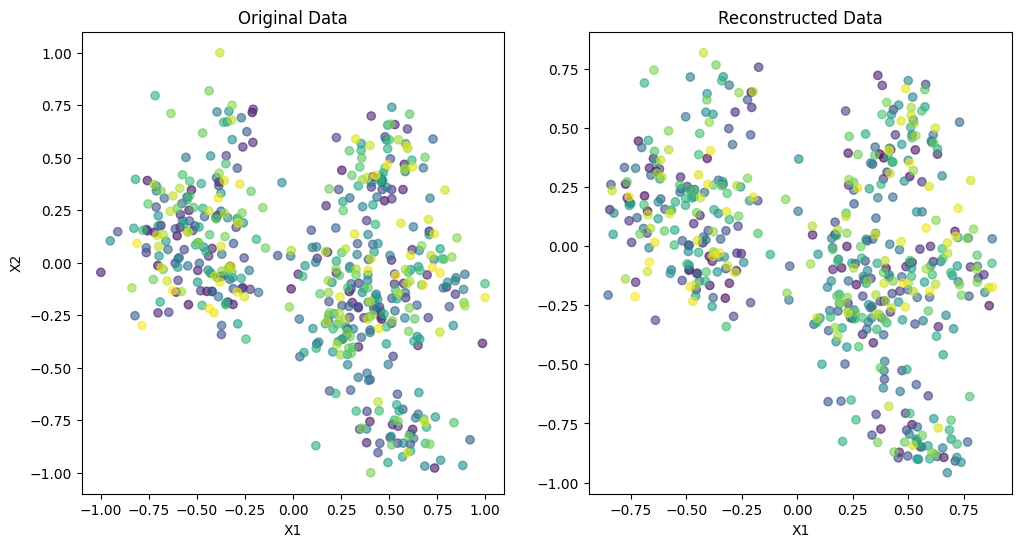

In [57]:
#@title Evaluation

def plot_vae_with_colors(X, model):
    model.eval()

    with torch.no_grad():
        # Reconstruct data through the VAE
        X_reconstructed, _, _ = model(X)
        X_reconstructed_np = X_reconstructed.detach().numpy()

    # Here, we sample from a normal distribution around the means
    X_reconstructed_sampled = np.random.normal(loc=X_reconstructed_np, scale=beta)

    # Generate a color map based on the index of each data point
    colors = plt.cm.viridis(np.linspace(0, 1, len(X)))

    # Plot original data
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(X[:, 0], X[:, 1], color=colors, alpha=0.6)
    plt.title('Original Data')
    plt.xlabel('X1')
    plt.ylabel('X2')

    # Plot reconstructed data
    plt.subplot(1, 2, 2)
    plt.scatter(X_reconstructed_sampled[:, 0], X_reconstructed_sampled[:, 1], color=colors, alpha=0.6)
    plt.title('Reconstructed Data')
    plt.xlabel('X1')

    plt.show()

plot_vae_with_colors(X, model)


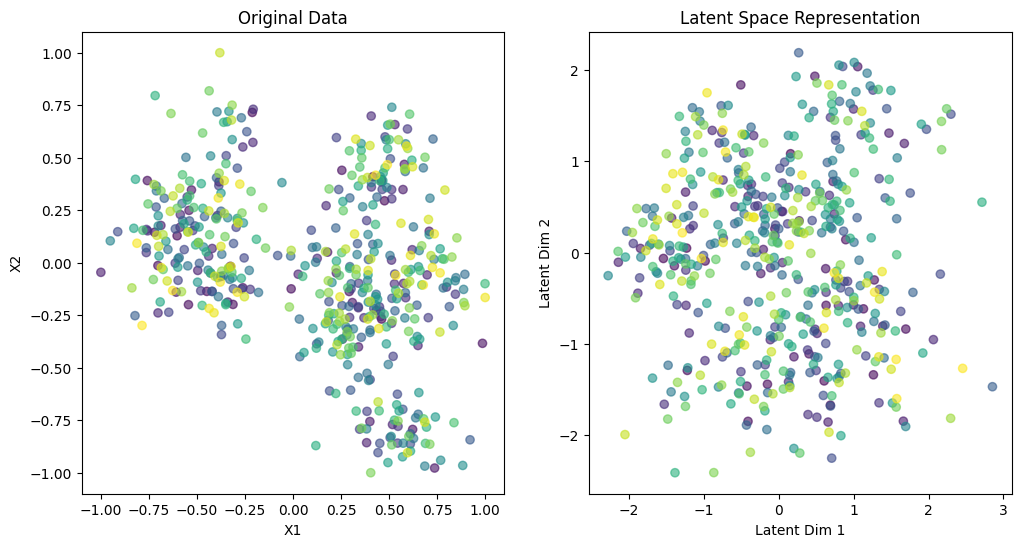

In [58]:
#@title Latent representation
def plot_data_and_latent_space(X, model):
    model.eval()

    with torch.no_grad():
        # Encode data to get the mean and log variance of the latent space distribution
        mu, log_var = model.encoder(X)
        std = torch.exp(0.5 * log_var)

        # Sample from the distribution using the reparameterization trick
        eps = torch.randn_like(std)
        z = mu + eps * std  # Reparameterized sample

        sampled_z_np = z.detach().numpy()

    # Generate a color map based on the index of each data point
    colors = plt.cm.viridis(np.linspace(0, 1, len(X)))

    # Plot original data
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.scatter(X[:, 0], X[:, 1], color=colors, alpha=0.6)
    plt.title('Original Data')
    plt.xlabel('X1')
    plt.ylabel('X2')

    # Plot latent space representation
    plt.subplot(1, 2, 2)
    plt.scatter(sampled_z_np[:, 0], sampled_z_np[:, 1], color=colors, alpha=0.6)
    plt.title('Latent Space Representation')
    plt.xlabel('Latent Dim 1')
    plt.ylabel('Latent Dim 2')

    plt.show()

plot_data_and_latent_space(X, model)


<ipython-input-59-d9599c9e1674>:26: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap))
<ipython-input-59-d9599c9e1674>:36: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap))


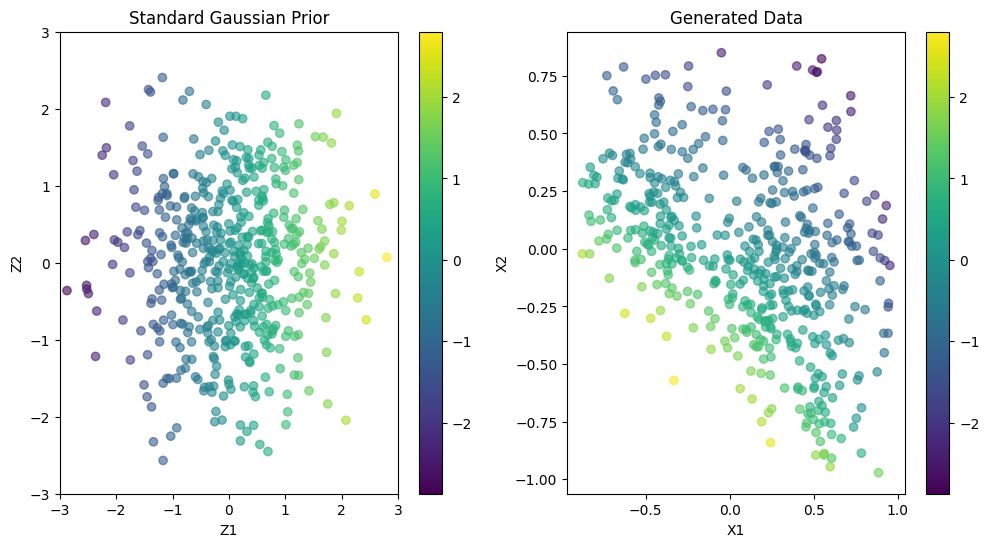

In [59]:
#@title Generating new samples

def plot_prior_and_generated_data_mapped_gradient(model, num_samples=500):
    model.eval()

    with torch.no_grad():
        # Sample from the prior (standard normal distribution in the latent space)
        z_samples = torch.randn(num_samples, latent_dim)

        # Decode the samples to generate data
        generated_means = model.decoder(z_samples).cpu().numpy()
        generated_data = np.random.normal(loc=generated_means, scale=beta)

    # Use the first dimension of z_samples for coloring both plots
    z_colors = z_samples[:, 0].numpy()

    # Create a colormap based on the first dimension of the latent samples
    norm = plt.Normalize(vmin=min(z_colors), vmax=max(z_colors))
    cmap = plt.get_cmap('viridis')
    colors = cmap(norm(z_colors))

    # Plot the standard Gaussian prior with a gradient color based on the first dimension
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(z_samples[:, 0], z_samples[:, 1], color=colors, alpha=0.6)
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap))
    plt.title('Standard Gaussian Prior')
    plt.xlim([-3, 3])
    plt.ylim([-3, 3])
    plt.xlabel('Z1')
    plt.ylabel('Z2')

    # Plot the generated data points with the same gradient color
    plt.subplot(1, 2, 2)
    plt.scatter(generated_data[:, 0], generated_data[:, 1], color=colors, alpha=0.6)
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap))
    plt.title('Generated Data')
    plt.xlabel('X1')
    plt.ylabel('X2')

    plt.show()

plot_prior_and_generated_data_mapped_gradient(model)


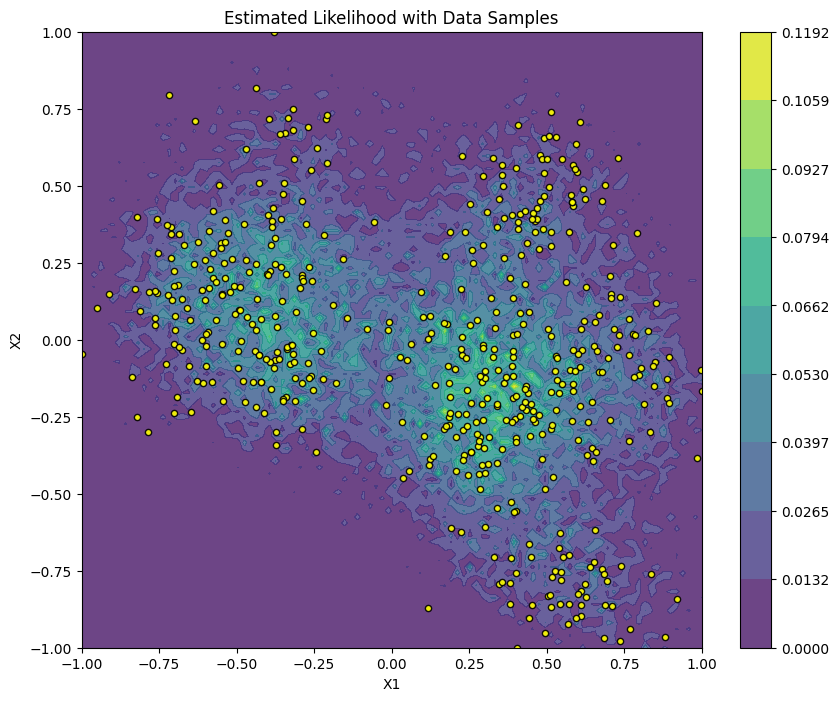

In [60]:
#@title Likelihood

def visualize_likelihood_on_grid_with_data_samples(decoder, X, latent_dim, grid_width=1, grid_height=1, grid_resolution=100, std_dev=0.1):
    # Define the grid over the data space
    x = np.linspace(-grid_width, grid_width, grid_resolution)
    y = np.linspace(-grid_height, grid_height, grid_resolution)
    X_grid, Y_grid = np.meshgrid(x, y)
    grid_shape = X_grid.shape

    # Flatten the grid for batch processing
    grid_points = np.vstack((X_grid.ravel(), Y_grid.ravel())).T

    # Convert to a PyTorch tensor
    grid_points_tensor = torch.from_numpy(grid_points).float()

    # Perform Monte Carlo approximation of the likelihood on the grid
    likelihoods = np.zeros(grid_points.shape[0])

    # Number of Monte Carlo samples
    num_samples = 100
    for _ in range(num_samples):
        # Sample z from the prior (standard normal)
        z_samples = torch.randn(len(grid_points), latent_dim)

        # Decode z to get x (mean of p(x|z))
        with torch.no_grad():
            x_samples = decoder(z_samples).cpu().numpy()

        # Compute the likelihood of the grid points under the Gaussian
        # Assume a Gaussian likelihood with a mean given by the decoder's output and some fixed std_dev
        for i, point in enumerate(grid_points):
            likelihoods[i] += np.exp(-0.5 * np.sum((point - x_samples[i])**2 / std_dev**2))

    # Average the likelihoods over the number of samples
    likelihoods /= num_samples

    # Reshape the likelihoods to the shape of the grid
    likelihoods = likelihoods.reshape(grid_shape)

    # Plot the likelihoods
    plt.figure(figsize=(10, 8))
    contour_levels = np.linspace(likelihoods.min(), likelihoods.max(), num=10)
    contour = plt.contourf(X_grid, Y_grid, likelihoods, levels=contour_levels, cmap='viridis', alpha=0.8)
    plt.colorbar(contour)

    # Normalize the original data points for coloring
    norm = plt.Normalize(X[:, 0].min(), X[:, 0].max())

    # Overlay the data samples on the likelihood plot
    plt.scatter(X[:, 0], X[:, 1], color='yellow', edgecolor='k', s=20, alpha=0.9)

    plt.title('Estimated Likelihood with Data Samples')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()

visualize_likelihood_on_grid_with_data_samples(model.decoder, X, latent_dim=2)
